#Decision Tree
1. First need to trim the SAL sequence list from 200 down to 150
    a. Cut tree into SAL and AHL, save trees off as NEXUS, get node ids
    b. split alignment into SAL and AHL
    c. trim SAL to 150 in t-coffee
2. Make a data frame with IDs and whether they are SAL or AHL
3. Run tree
4. Repeat but with residues labelled by attribute (polarity, charge, special function)


# This section is the random forest code from Dana Matthews

In [108]:
import numpy as np
import pandas as pd
import pprint as pp

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, KFold, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [ ]:
# Credit to Dana Matthews for writing the original code

def tokenise(sequence_data):
    
    '''
    Sequence data is in the form of a panda Series containing the sequences in string form. 
    '''
    
    all_seq = []
    tokens = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
              'E': 6, 'Q': 7, 'G': 8, 'H': 9, 'I': 10,
              'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
              'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
              '-':21
              }
    for sequence in sequence_data: 
        seq = []
        for letter in sequence:
            seq.append(tokens[letter])
        all_seq.append(np.array(seq))
    return np.array(all_seq)

def detokenise(tokenised_seq_data):
    final_seq = []
    tokens = {1: 'A', 2: 'R', 3: 'N', 4: 'D', 5: 'C',
              6: 'E', 7: 'Q', 8: 'G', 9: 'H', 10: 'I',
              11: 'L', 12: 'K', 13: 'M', 14: 'F', 15: 'P',
              16: 'S', 17: 'T', 18: 'W', 19: 'Y', 20: 'V',
              
              }
    for sequence in tokenised_seq_data: 
        seq = []
        for number in sequence:
            seq.append(tokens[number])
        seq = ''.join(seq)
        final_seq.append(seq)
    return final_seq

In [ ]:
# Credit to Dana Matthews for writing the original code

# Maybe replace thie with my entropy equation

def mutations_in(X): 
    position_mutations = {}
    for i in range(len(X[0])):
        position_mutations[i] = []
        position_list = []
        position_ratios = []
        for j in range(len(X)):
            position_list.append(X[j][i])
        position_mutations[i].append(set(position_list))
        for mutant in position_mutations[i][0]:
            ratio = position_list.count(mutant)/len(position_list)
            position_ratios.append(ratio)
        position_ratios = [round(x / sum(position_ratios), 3) for x in position_ratios]
        position_mutations[i].append(position_ratios)
    return position_mutations

In [71]:
X = data.drop(['seq_id', 'paralogue'],axis=1)
y = data['paralogue']

In [76]:
# Initial data split, the test set will be the final data to be tested against and not used in hyperparameter determination for the Random Forest 
#def test_split(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
#    return X_train, X_test, y_train, y_test

In [77]:
# Write my decision tree code here

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)


DecisionTreeClassifier()

In [78]:
predictions = dtree.predict(X_test)

print("Report:")
print(classification_report(y_test,predictions))
print("\n")
print("Confusion matrix:")
print(confusion_matrix(y_test,predictions))

Report:
              precision    recall  f1-score   support

         AHL       1.00      1.00      1.00        21
         SAL       0.97      1.00      0.99        34
         UIM       1.00      0.97      0.99        35

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



Confusion matrix:
[[21  0  0]
 [ 0 34  0]
 [ 0  1 34]]


[Text(133.92000000000002, 181.2, 'X[130] <= 20.5\ngini = 0.666\nsamples = 360\nvalue = [129, 116, 115]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 129\nvalue = [129, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[408] <= 20.5\ngini = 0.5\nsamples = 231\nvalue = [0, 116, 115]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 115\nvalue = [0, 0, 115]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 116\nvalue = [0, 116, 0]')]

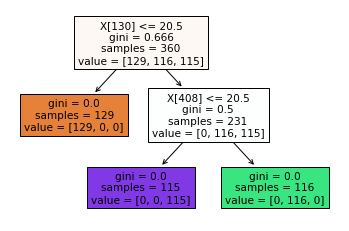

In [80]:
tree.plot_tree(dtree, filled=True) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Credit to Dana Matthews for writing the original code

def nested_hyperparam_selection(X = X_train, y = y_train, random_grid, random_state=42, outer_k=5, inner_k=5, search_iterations=100, verbose=2):
    '''
    X: np.array of sequences which are in the form of a np.array of tokens.
    y: np.array of activities (or other features) which are in the form of float.64s. 
    random_grid: dictionary of hyperparameters to test - example below. 
    '''
    
    rf = RandomForestRegressor(n_jobs=-1)

    # split and results storage
    outer_splits = []
    results = {}

    
    
    # outer data split
    kf = KFold(n_splits=outer_k)
    kf.get_n_splits(X)
    for train_i, test_i in kf.split(X):
        X_train, X_val, y_train, y_val = X[train_i], X[test_i], y[train_i], y[test_i]
        outer_splits.append([X_train, X_val, y_train, y_val])

    # determining best hyperparameters for each k outer split
    for i in range(outer_k):
        X_train, X_val, y_train, y_val = outer_splits[i]
        rand_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=search_iterations, 
                                         scoring='neg_mean_squared_error', cv=inner_k, verbose=verbose, 
                                         random_state=random_state, n_jobs=-1    
                                         )
        rand_search.fit(X_train, y_train)
        rand_search_results = rand_search.cv_results_
        df_rand_search_results = pd.DataFrame(rand_search_results).sort_values(by='rank_test_score').reset_index(drop=True)

        param_vals = df_rand_search_results._get_value(0, 'params')
        score_val = df_rand_search_results._get_value(0, 'mean_test_score')
        rf.set_params(**param_vals)

        results['From Split ' + str(i)] = {'Parameters': param_vals,
                                           'Score': score_val
                                           }
        # testing method on all k outer splits
        for k in range(outer_k):
            X_train, X_val, y_train, y_val = outer_splits[k]
            rf.fit(X_train, y_train)
            test_pred = rf.predict(X_val)
            test_r2 = rf.score(X_val, y_val)
            train_pred = rf.predict(X_train)
            train_r2 = rf.score(X_train, y_train)   
            results['From Split ' + str(i)]['On Split ' + str(k)] = {'Test Prediction': test_pred, 'Test R2': test_r2, 
                                                                     'Train Prediction': train_pred, 'Train R2': train_r2
                                                                     }
    return results

def hyperparam_avg_scores(outer_k, results):
    avg_results = {}
    for i in range(outer_k):
        test_average = 0
        train_average = 0
        for k in range(outer_k):
            test_r2 = results['From Split ' + str(i)]['On Split ' + str(k)]['Test R2']
            train_r2 = results['From Split ' + str(i)]['On Split ' + str(k)]['Train R2']
            test_average += test_r2
            train_average += train_r2
        test_average /= outer_k
        train_average /= outer_k
        avg_results['From Split ' + str(i)] = {'Average test R2': test_average, 
                                               'Average train R2': train_average
                                               }
    return avg_results

def weighted_hyperparam_set(outer_k, results, print_res=False):
    # determining weights
    avg_results = hyperparam_avg_scores(outer_k, results)
    weight_list = []
    for i in range(outer_k):
        R2_test = avg_results['From Split ' + str(i)]['Average test R2']
        R2_train = avg_results['From Split ' + str(i)]['Average train R2']
        R2_test = (1 - R2_test) / outer_k
        R2_train = (1- R2_train) * (outer_k - 1) / outer_k
        R2_both = R2_test + R2_train
        R2_both = 1 / R2_both
        weight_list.append(R2_both)
    weight_list = [x / sum(weight_list) for x in weight_list]
    
    if print_res==True: 
        print('''Weights of each hyperparameter set:
              ''')
        for i in range(outer_k):
            print('*From Split {} weight: {}'.format(i, weight_list[i]))
            pp.pprint(results['From Split ' + str(i)]['Parameters'])
            print()

    # using weights to determine final hyperparameter set
    avg_param = {}
    for param in results['From Split ' + str(0)]['Parameters'].keys():
        if type(results['From Split ' + str(0)]['Parameters'][param]) == int: 
            avg_param_val = 0
            for i in range(outer_k):
                avg_param_val += results['From Split ' + str(i)]['Parameters'][param] * weight_list[i]
            avg_param[param] = round(avg_param_val)
        elif type(results['From Split ' + str(0)]['Parameters'][param]) == str:
            temp_dict = {}
            for i in range(outer_k):
                param_str = results['From Split ' + str(i)]['Parameters'][param]
                if not param_str in temp_dict:
                    temp_dict[param_str] = weight_list[i]
                else:
                    temp_dict[param_str] += weight_list[i]
            winning_hyperparam = max(temp_dict, key=lambda k: temp_dict[k])
            avg_param[param] = winning_hyperparam
            
    return weight_list, avg_param

In [ ]:
# Credit to Dana Matthews for writing the original code

random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=20)],
               'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_split': [1, 2, 4, 16, 32],
               'min_samples_leaf': [1, 2, 4, 16]
               }

In [ ]:
# Credit to Dana Matthews for writing the original code

def final_cv(parameters_dict, k, X, y, print_res=False):  
    '''
    parameters_dict: final hyperparameter set you found above.
    k: what k you want for your k-fold cross validation.
    X: np.array of sequences which are in the form of a np.array of tokens.
    y: np.array of activities (or other features) which are in the form of float.64s. 
    print_res: if set to True, will print results when function is ran. 
    '''
    
    rf = RandomForestRegressor(n_jobs=-1)
    rf.set_params(**parameters_dict)
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)

    final_splits = []
    final_split_results = {'Y Actual': [], 'Y Predicted': [], 'R2': []}

    for train_i, test_i in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_i], X[test_i], y[train_i], y[test_i]
        final_splits.append([X_train, X_test, y_train, y_test])

    for i in range(k):
        X_train, X_test, y_train, y_test = final_splits[i]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        final_split_results['Y Actual'].append(y_test.to_list())
        final_split_results['Y Predicted'].append(y_pred)
        final_split_results['R2'].append(r2)
        
    avg_final_split_result = sum(final_split_results['R2'])/len(final_split_results['R2'])
    
    if print_res == True:
        print('R2 for each fold: ', final_split_results['R2'])
        print()
        print('Average R2: ', avg_final_split_result)
    
    return final_split_results, avg_final_split_result

In [ ]:
# Credit to Dana Matthews for writing the original code

def loocv(parameters_dict, dataset, X, y):
    '''
    parameters_dict: final hyperparameter set you found above.
    dataset: the csv/excel speadsheet data was loaded from. This is included so that the name of the mutant will be printed
        out.
    X: np.array of sequences which are in the form of a np.array of tokens.
    y: np.array of activities (or other features) which are in the form of float.64s. 
    print_res: if set to True, will print results when function is ran. 
    '''
    rf = RandomForestRegressor(n_jobs=-1)
    rf.set_params(**parameters_dict)

    mutant_errors = {}
    # LOOCV splits: 
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    loo_splits = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        loo_splits.append([X_train, X_test, y_train, y_test])

    # running final model on each split:
    for i in range(len(X)):
        X_train, X_test, y_train, y_test = loo_splits[i]
        rf.fit(X_train, y_train)
        test_pred = rf.predict(X_test)
        test_mae = mean_absolute_error(y_test, test_pred)
        train_pred = rf.predict(X_train)
        train_mae = mean_absolute_error(y_train, train_pred)
        mutant_errors['On mutant ' + str(i)] = {'Test Prediction': test_pred, 'Test MAE': test_mae,
                                                'Train Prediction': train_pred, 'Train MAE': train_mae
                                                }
    mutant_seq_errors = {'Mutant Name': [], 'Actual activity': [], 'Predicted activity': [], 'MAE': []}
    for i in range(len(loo_splits)):
        sequence_tokenised = loo_splits[i][1]
        sequence = detokenise(sequence_tokenised)
        name = dataset.loc[dataset['Sequence'] == sequence[0], 'Mutant Name'].iloc[0]
        pred = round(mutant_errors['On mutant ' + str(i)]['Test Prediction'][0], 3)
        mae = round(mutant_errors['On mutant ' + str(i)]['Test MAE'], 5)
        mutant_seq_errors['Mutant Name'].append(name)
        mutant_seq_errors['MAE'].append(mae)
        mutant_seq_errors['Actual activity'].append(y[i])
        mutant_seq_errors['Predicted activity'].append(pred)

    mutant_df = pd.DataFrame(mutant_seq_errors).sort_values('MAE', ascending=False)
    display(mutant_df)
    
    return mutant_seq_errors

In [ ]:
# Credit to Dana Matthews for writing the original code

def feature_importance(parameters_dict, X, y, position_mutations, n_repeats=10):   
    '''
    parameters_dict: final hyperparameter set you found above.
    X: np.array of sequences which are in the form of a np.array of tokens.
    y: np.array of activities (or other features) which are in the form of float.64s. 
    position_mutations: dictionary from `mutations_in` function. 
    '''
    rf = RandomForestRegressor(n_jobs=-1)
    rf.set_params(**parameters_dict)
    rf.fit(X, y)
    
    # feature importance
    feature_dict = {'Position': [], 'Feature Importance': [], 'Feat. Std Dev': []}
    importances_mean = rf.feature_importances_
    importances_sd = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances_mean)[::-1]
    for i in range(len(X[0])):
        feature_dict['Position'].append(indices[i] + 1)
        feature_dict['Feature Importance'].append(importances_mean[indices[i]])
        feature_dict['Feat. Std Dev'].append(importances_sd[indices[i]])
       
    # permutation importance
    perm_feature_dict = {'Position': [], 'Permutation Importance': [], 'Perm. Std Dev': []}
    perm_importances = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=42, n_jobs=-1)
    sorted_idx = np.flip(perm_importances.importances_mean.argsort())
    perm_importances_mean = perm_importances.importances_mean
    perm_importances_std = perm_importances.importances_std
    for i in sorted_idx:
        perm_feature_dict['Position'].append(sorted_idx[i] + 1)
        perm_feature_dict['Permutation Importance'].append(perm_importances_mean[sorted_idx[i]])
        perm_feature_dict['Perm. Std Dev'].append(perm_importances_std[sorted_idx[i]])
        
    # position information
    position_inf_dict = {'Position': [], '# Mutations': [], '# Sequences with Mutation': []}
    for i in range(len(X[0])):
        position_inf_dict['Position'].append(i + 1)
        position_inf_dict['# Mutations'].append(len(position_mutations[i][0]))
        position_inf_dict['# Sequences with Mutation'].append(position_mutations[i][1])
    
    feature_df = pd.DataFrame(feature_dict)
    perm_df = pd.DataFrame(perm_feature_dict)
    position_df = pd.DataFrame(position_inf_dict)
    merged_df = feature_df.merge(perm_df)
    merged_df = merged_df.merge(position_df)
    
    display(merged_df.sort_values('Permutation Importance', ascending=False))
    
    return merged_df

In [ ]:
# Make an alignment with equal number of each paralogue (i.e. thin the SAL1 from 200 to 150)

In [89]:
# Dataformating 

tokens = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
          'E': 6, 'Q': 7, 'G': 8, 'H': 9, 'I': 10,
          'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
          'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
          '-':21
          }

paralogues = ['ahl', 'sal', 'uim']

for para in paralogues:

    with open (f'{para}_ml_f.fasta', 'r') as aln:

        temp_dict = {}
        toks_dict = {}
        x = ''
        y = ''

        # Converts the orignal, aligned and not trimmed, fasta file into a dictionary where the key is fasta header and the value is the sequence
        for line in aln:

            if line.startswith('>'):
                line = line[:6]
                x = line.strip('\n').lstrip('>')
                x = str(x)
            else:
                y = line.strip('\n')
            temp_dict.update({x: y}) 

    #need to tokenise each residue in temp_dict
    # so iteratively take each value and then iteratively replace then save to a new dictionary


        for x, y in temp_dict.items():
            toks = []
            for letter in y:
                toks.append(tokens[letter.upper()])
            toks_dict.update({x: toks})    
        
        if para =='ahl':
            ahl = pd.DataFrame(list(toks_dict.items()),columns = ['seq_id','token_seq'])
            ahl['paralogue']='AHL'
        elif para =='sal':
            sal = pd.DataFrame(list(toks_dict.items()),columns = ['seq_id','token_seq'])
            sal['paralogue']='SAL'
        elif para =='uim':
            uim = pd.DataFrame(list(toks_dict.items()),columns = ['seq_id','token_seq'])
            uim['paralogue']='UIM'
            
    frames = [ahl, sal, uim]
    data = pd.concat(frames)

In [90]:
col = np.arange(0, 473, 1) # 473 is the alignment length
cols = []

for n in col:
    z = str(n)
    cols.append(z)

data[cols] = pd.DataFrame(data.token_seq.tolist(), index= data.index)

data = data.drop('token_seq',axis=1)

In [98]:
# Instead of using a token table this uses a onehot encoder 

paralogues = ['ahl', 'sal', 'uim']

for para in paralogues:

    with open (f'{para}_ml_f.fasta', 'r') as aln:

        temp_dict = {}
        toks_dict = {}
        x = ''
        y = ''

        # Converts the orignal, aligned and not trimmed, fasta file into a dictionary where the key is fasta header and the value is the sequence
        for line in aln:

            if line.startswith('>'):
                line = line[:6]
                x = line.strip('\n').lstrip('>')
                x = str(x)
            else:
                y = line.strip('\n')
            temp_dict.update({x: y}) 

    #need to tokenise each residue in temp_dict
    # so iteratively take each value and then iteratively replace then save to a new dictionary
       
        if para =='ahl':
            ahl = pd.DataFrame(list(temp_dict.items()),columns = ['seq_id','seq'])
            ahl['paralogue']='AHL'
        elif para =='sal':
            sal = pd.DataFrame(list(temp_dict.items()),columns = ['seq_id','seq'])
            sal['paralogue']='SAL'
        elif para =='uim':
            uim = pd.DataFrame(list(temp_dict.items()),columns = ['seq_id','seq'])
            uim['paralogue']='UIM'
            
    frames = [ahl, sal, uim]
    data = pd.concat(frames)




In [99]:
data

,seq_id,seq,paralogue
0,10086,---------ys----------yeldvavkavqiacslcqkv-qegl...,AHL
1,10748,---------yc----------keldaavravqvacflcqkl-qdsl...,AHL
2,12212,---------yd----------lelnvavrvvhmvcslcqkv-qkel...,AHL
3,12371,---------ya----------keldvavrvvhmacslcqrv-qegl...,AHL
4,13097,---------ye----------melevavkavqlscilsqri-qqrv...,AHL
...,...,...,...
145,48433,lpfpkenakyh----------keleaaidvvhsacrlcvqv-kssl...,UIM
146,25110,lpfpiqkatyh----------eelraavdvvdracrlcvdv-qrsl...,UIM
147,78575,lpfpeksskyy----------khleaavevvqrasslcvdv-kssl...,UIM
148,33769,---------yq----------refeaaidvverachlcaiv-qqsi...,UIM


In [106]:
col = np.arange(0, 473, 1) # 473 is the alignment length
cols = []

for n in col:
    z = str(n)
    cols.append(z)

data2 = pd.DataFrame(data['seq'].str.split('').tolist(), index= data.index)

# data = data.drop('seq',axis=1)

In [107]:
data2

,0,1,2,3,4,5,6,7,8,9,...,465,466,467,468,469,470,471,472,473,474
0,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
1,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
2,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
3,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
4,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,,l,p,f,p,k,e,n,a,k,...,-,-,-,-,-,-,-,-,-,
146,,l,p,f,p,i,q,k,a,t,...,-,-,-,-,-,-,-,-,-,
147,,l,p,f,p,e,k,s,s,k,...,-,-,-,-,-,-,-,-,-,
148,,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,


In [1]:
enc = preprocessing.OneHotEncoder()

enc.fit(X)
OneHotEncoder()

NameError: name 'preprocessing' is not defined

Text(0.5, 0, 'Sequence space')

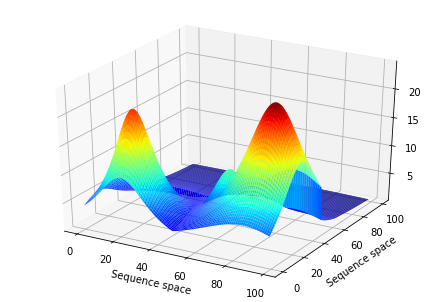

In [51]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

try:
    import numpy as np
except:
    exit()

import random
rnd = random.Random()
rnd.seed(128)

from deap.benchmarks import movingpeaks

sc = movingpeaks.SCENARIO_1
sc["uniform_height"] = 0
sc["uniform_width"] = 0
sc["npeaks"] = 3
sc["min_width"] = 0.001
sc["max_width"] = 0.02
sc["max_height"] = 30
sc["min_height"] = 10
sc["min_coord"] = 10
sc["max_coord"] = 90

mp = movingpeaks.MovingPeaks(dim=3, random=rnd, **sc)

fig = plt.figure()
ax = Axes3D(fig)
X = np.arange(0, 100, 1.0)
Y = np.arange(0, 100, 1.0)
X, Y = np.meshgrid(X, Y)
Z = np.fromiter(map(lambda x: mp(x)[0], zip(X.flat,Y.flat)), dtype=np.float, count=X.shape[0]*X.shape[1]).reshape(X.shape)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

plt.xlabel("Sequence space")
plt.ylabel("Sequence space")